In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


In [2]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap([qubit], [n-qubit-1])
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h([j])
    qc.name = "QFT†"
    return qc

In [3]:
def controlled_draper_adder(a,n):
    
    a_bin = [int(x) for x in bin(a)[2:]]
    a_bin.reverse()
    a_bin = (a_bin + n * [0])[:n]
    a_bin.reverse()
    
    qc = QuantumCircuit(n+1)
    
    qc.append(qft_dagger(n).inverse(),[1+i for i in range(n)])
    
    for i in range(n):
        for j in range(n-i):
            if a_bin[i+j] == 1:
                qc.crz(2*np.pi/pow(2,j+1),0,1+i)
    
    qc.append(qft_dagger(n),[1+i for i in range(n)])
    
    qc.name = "%i_adder_%i_qubit" % (a,n)
    
    return qc

In [4]:
qc = controlled_draper_adder(3,3)
qc.draw('text')

q_0: ─────────────────■──────────■─────────■─────────■─────────■─────────────
     ┌──────────┐┌────┴────┐┌────┴────┐    │         │         │    ┌───────┐
q_1: ┤0         ├┤ RZ(π/2) ├┤ RZ(π/4) ├────┼─────────┼─────────┼────┤0      ├
     │          │└─────────┘└─────────┘┌───┴───┐┌────┴────┐    │    │       │
q_2: ┤1 QFT†_dg ├──────────────────────┤ RZ(π) ├┤ RZ(π/2) ├────┼────┤1 QFT† ├
     │          │                      └───────┘└─────────┘┌───┴───┐│       │
q_3: ┤2         ├──────────────────────────────────────────┤ RZ(π) ├┤2      ├
     └──────────┘                                          └───────┘└───────┘

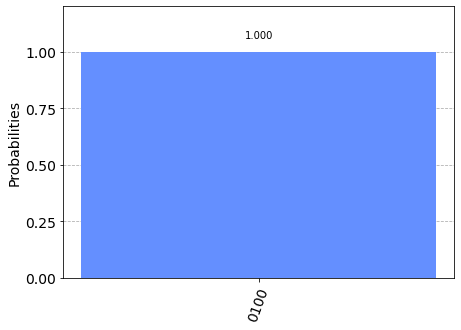

In [5]:
a = 7
b = 4
c = 0
n = 4

b_bin = [int(x) for x in bin(b)[2:]]
b_bin.reverse()

adder_n_qubit_test = QuantumCircuit(n+1,n)

## Initialize b and control

if c == 1:
    adder_n_qubit_test.x([0])

for i in range(len(b_bin)):
    if b_bin[i] == 1:
        adder_n_qubit_test.x([1+i])
        
## Insert adder

adder_n_qubit_test.append(controlled_draper_adder(a,n),[i for i in range(n+1)])

## Measure b

adder_n_qubit_test.measure([1+i for i in range(n)],[i for i in range(n)])

adder_n_qubit_test.draw('text')

## Simulate

backend = Aer.get_backend('qasm_simulator')
results = execute(adder_n_qubit_test, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [6]:
#############################################################################################
#Computes modular-N sum of n-bit numbers a and b and stores result in b if control bit is one
#a is not an input but a classical value which determines circuit topology
#############################################################################################

def modular_adder_n_qubit(a,N,n):
    
    ## Converting decimal N to binary list
    
    z = [int(x) for x in bin(N)[2:]]
    z.reverse()
    
    qc = QuantumCircuit(n+3)
    
    qc.x([n+2])
    
    ## Compute sum of a and b
    
    qc.append(controlled_draper_adder(a,n+1),[i for i in range(n+2)])
    
    ## Substract N by using inverse addition block
    
    qc.append(controlled_draper_adder(N,n+1).inverse(),[n+2] + [1+i for i in range(n+1)])
    
    ## If an overflow occurs (e.g. a+b-N<0) add N
    # Overflow is indicated by the most significant bit of b
    # This value is stored in a temporary bit t
    
    qc.x([n+1])
    qc.cx([n+1],[n+2])
    qc.x([n+1])
    
    # If t indicates an overflow, N is added back

    qc.append(controlled_draper_adder(N,n+1),[n+2] + [1+i for i in range(n+1)])
        
    ## Reset temporary bit t to zero
    
    qc.append(controlled_draper_adder(a,n+1).inverse(),[i for i in range(n+2)])
    qc.cx([n+1],[n+2])
    qc.append(controlled_draper_adder(a,n+1),[i for i in range(n+2)])
    qc.x([n+2])
    
    qc.name = "%i_modular_%i_adder_%i_qubit" %(a,N,n)
    return qc

In [7]:
qc = modular_adder_n_qubit(3,7,3)
qc.draw('text')

┌──────────────────┐                                      »
q_0: ┤0                 ├──────────────────────────────────────»
     │                  │┌─────────────────────┐               »
q_1: ┤1                 ├┤1                    ├───────────────»
     │                  ││                     │               »
q_2: ┤2 3_adder_4_qubit ├┤2                    ├───────────────»
     │                  ││                     │               »
q_3: ┤3                 ├┤3 7_adder_4_qubit_dg ├───────────────»
     │                  ││                     │┌───┐     ┌───┐»
q_4: ┤4                 ├┤4                    ├┤ X ├──■──┤ X ├»
     └──────┬───┬───────┘│                     │└───┘┌─┴─┐└───┘»
q_5: ───────┤ X ├────────┤0                    ├─────┤ X ├─────»
            └───┘        └─────────────────────┘     └───┘     »
«                         ┌─────────────────────┐     ┌──────────────────┐
«q_0: ────────────────────┤0                    ├─────┤0                 ├
«     ┌──────────────────┐│                     │     │                  │
«q_1: ┤1                 ├┤1                    ├─────┤1                 ├
«     │                  ││                     │     │                  │
«q_2: ┤2                 ├┤2 3_adder_4_qubit_dg ├─────┤2 3_adder_4_qubit ├
«     │                  ││                     │     │                  │
«q_3: ┤3 7_adder_4_qubit ├┤3                    ├─────┤3                 ├
«     │                  ││                     │     │                  │
«q_4: ┤4                 ├┤4                    ├──■──┤4                 ├
«     │                  │└─────────────────────┘┌─┴─┐└──────┬───┬───────┘
«q_5: ┤0                 ├───────────────────────┤ X ├───────┤ X ├────────
«     └──────────────────┘                       └───┘       └───┘

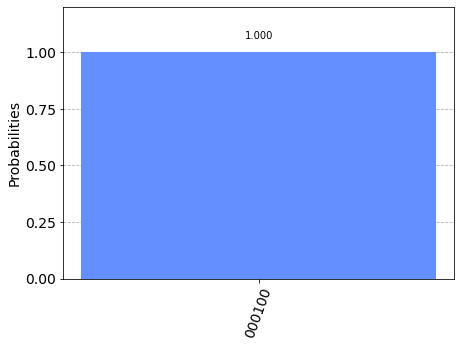

In [8]:
##############################################
# Test code n-qubit modular adder
##############################################

c=1
a=7
b=8
N=11
n=4

## Convert decimal number to binary list

b_bin = [int(x) for x in bin(b)[2:]]
b_bin.reverse()

modular_adder_n_qubit_test = QuantumCircuit(n+3,n+2)

## Initialize b and control

if c == 1:
    modular_adder_n_qubit_test.x([0])

for i in range(len(b_bin)):
    if b_bin[i] == 1:
        modular_adder_n_qubit_test.x([1+i])
        
## Insert modular adder

modular_adder_n_qubit_test.append(modular_adder_n_qubit(a,N,n),[i for i in range(n+3)])

## Measure b

modular_adder_n_qubit_test.measure([1+i for i in range(n+1)] + [n+2],[i for i in range(n+2)])

modular_adder_n_qubit_test.draw('text')

##Simulate

backend = Aer.get_backend('qasm_simulator')
results = execute(modular_adder_n_qubit_test, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [9]:
############################################################################################################
# Computes modular multiplication of two n-bit number z and m and stores result in b if control bit c is one
# Stores z in b if c is zero
# m is not an input but a classical value which determines circuit topology
############################################################################################################

def modular_multiplicator_n_qubit(m,N,n):
        
    qc = QuantumCircuit(2*n+4)
    
    ## Add m^(2^i) mod N if zi and c are one for every bit of z
    
    for i in range(n):
        #Compute m^(2^i) mod N
        a = m*pow(2,i) % N
        #Perform modular addition if c and zi are one
        qc.ccx([0],[1+i],[n+1])
        qc.append(modular_adder_n_qubit(a,N,n),[n+1+x for x in range(n+3)])
        #Reset control bit of modular adder
        qc.ccx([0],[1+i],[n+1])
                
    ## Store z in b if c is zero
    
    qc.x([0])
    for i in range(n):
        qc.ccx([0],[1+i],[n+2+i])
    qc.x([0])
    
    qc.name = "%i_modular_%i_multiplicator_%i_qubit" %(m,N,n)
    return qc

In [10]:
qc = modular_multiplicator_n_qubit(3,5,3)
qc.draw('text')

»
q_0: ──■──────────────────────────────────■────■──»
       │                                  │    │  »
q_1: ──■──────────────────────────────────■────┼──»
       │                                  │    │  »
q_2: ──┼──────────────────────────────────┼────■──»
       │                                  │    │  »
q_3: ──┼──────────────────────────────────┼────┼──»
     ┌─┴─┐┌────────────────────────────┐┌─┴─┐┌─┴─┐»
q_4: ┤ X ├┤0                           ├┤ X ├┤ X ├»
     └───┘│                            │└───┘└───┘»
q_5: ─────┤1                           ├──────────»
          │                            │          »
q_6: ─────┤2                           ├──────────»
          │  3_modular_5_adder_3_qubit │          »
q_7: ─────┤3                           ├──────────»
          │                            │          »
q_8: ─────┤4                           ├──────────»
          │                            │          »
q_9: ─────┤5                           ├──────────»
          └────────────────────────────┘          »
«                                                                           »
«q_0: ────────────────────────────────■────■────────────────────────────────»
«                                     │    │                                »
«q_1: ────────────────────────────────┼────┼────────────────────────────────»
«                                     │    │                                »
«q_2: ────────────────────────────────■────┼────────────────────────────────»
«                                     │    │                                »
«q_3: ────────────────────────────────┼────■────────────────────────────────»
«     ┌────────────────────────────┐┌─┴─┐┌─┴─┐┌────────────────────────────┐»
«q_4: ┤0                           ├┤ X ├┤ X ├┤0                           ├»
«     │                            │└───┘└───┘│                            │»
«q_5: ┤1                           ├──────────┤1                           ├»
«     │                            │          │                            │»
«q_6: ┤2                           ├──────────┤2                           ├»
«     │  1_modular_5_adder_3_qubit │          │  2_modular_5_adder_3_qubit │»
«q_7: ┤3                           ├──────────┤3                           ├»
«     │                            │          │                            │»
«q_8: ┤4                           ├──────────┤4                           ├»
«     │                            │          │                            │»
«q_9: ┤5                           ├──────────┤5                           ├»
«     └────────────────────────────┘          └────────────────────────────┘»
«          ┌───┐               ┌───┐
«q_0: ──■──┤ X ├──■────■────■──┤ X ├
«       │  └───┘  │    │    │  └───┘
«q_1: ──┼─────────■────┼────┼───────
«       │         │    │    │       
«q_2: ──┼─────────┼────■────┼───────
«       │         │    │    │       
«q_3: ──■─────────┼────┼────■───────
«     ┌─┴─┐       │    │    │       
«q_4: ┤ X ├───────┼────┼────┼───────
«     └───┘     ┌─┴─┐  │    │       
«q_5: ──────────┤ X ├──┼────┼───────
«               └───┘┌─┴─┐  │       
«q_6: ───────────────┤ X ├──┼───────
«                    └───┘┌─┴─┐     
«q_7: ────────────────────┤ X ├─────
«                         └───┘     
«q_8: ──────────────────────────────
«                                   
«q_9: ──────────────────────────────
«

In [11]:
######################################
# Test code n-qubit modular multiplier
######################################

c=1
z=5
m=7
N=11
n=4

## Convert decimal number to binary list

z_bin = [int(x) for x in bin(z)[2:]]
z_bin.reverse()

modular_multiplicator_n_qubit_test = QuantumCircuit(2*n+4,n+1)

## Initialize c and z

if c == 1:
    modular_multiplicator_n_qubit_test.x([0])
for i in range(len(z_bin)):
    if z_bin[i] == 1:
        modular_multiplicator_n_qubit_test.x(1+i)
        
## Insert modular multiplicator

modular_multiplicator_n_qubit_test.append(modular_multiplicator_n_qubit(m,N,n),[i for i in range(2*n+4)])

## Measure b

modular_multiplicator_n_qubit_test.measure([n+2+i for i in range(n+1)],[i for i in range(n+1)])

modular_multiplicator_n_qubit_test.draw('text')

##Simulate

backend = Aer.get_backend('qasm_simulator')
results = execute(modular_multiplicator_n_qubit_test, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [12]:
######################################################################################
# Computes y^x mod N and stores result in z where y is an n-bit and x a 2-n bit number
# y is not an input but a classical value which determines circuit topology
######################################################################################

def modular_exponentiator_n_qubit(N,y,n):
    
    qc = QuantumCircuit(4*n+3)
    
    ## Multiply by y^(2^i)*xi for every bit of x
    
    for q in range(2*n):
        # Performing multiplication
        qc.append(modular_multiplicator_n_qubit(pow(y,pow(2,q)),N,n),[q] + [2*n+i for i in range(2*n+3)])
        # Swapping z with b
        for r in range(n):
            qc.cswap([q],[2*n+r],[3*n+1+r])
        # Resetting b to zero
        qc.append(modular_multiplicator_n_qubit(pow(pow(y,pow(2,q)),-1,N),N,n).inverse(),[q] + [2*n+i for i in range(2*n+3)])
        
    qc.name = "%i_modular_%i_exponentiator_%i_qubit" %(y,N,n)
    return qc

In [13]:
qc = modular_exponentiator_n_qubit(5,3,3)
#qc.draw('text')

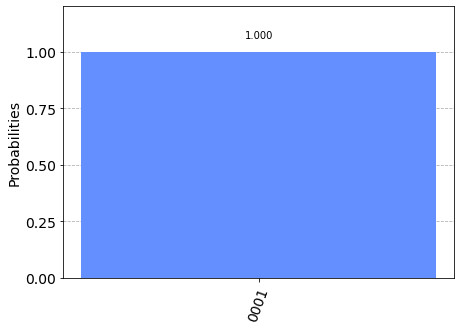

In [14]:
#########################################
# Test code n-qubit modular exponentiator
#########################################

x=4
z=1
N=15
y=2
n=len([int(i) for i in bin(N)[2:]])

## Convert decimal number to binary list

x_bin = [int(i) for i in bin(x)[2:]]
z_bin = [int(i) for i in bin(z)[2:]]
x_bin.reverse()
z_bin.reverse()

modular_exponentiator_n_qubit_test = QuantumCircuit(4*n+3,n)

## Initialize x and z

for i in range(len(x_bin)):
    if x_bin[i] == 1:
        modular_exponentiator_n_qubit_test.x([i])
for i in range(len(z_bin)):
    if z_bin[i] == 1:
        modular_exponentiator_n_qubit_test.x([2*n+i])

## Insert modular exponentiator

modular_exponentiator_n_qubit_test.append(modular_exponentiator_n_qubit(N,y,n),[i for i in range(4*n+3)])

## Measure z

modular_exponentiator_n_qubit_test.measure([2*n+i for i in range(n)],[i for i in range(n)])


modular_exponentiator_n_qubit_test.draw('text')

##Simulate

backend = Aer.get_backend('qasm_simulator')
results = execute(modular_exponentiator_n_qubit_test, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [15]:
###########################################################
#Authentication Code Needed for the Quantum-Inspire Backend
###########################################################
import os
from getpass import getpass
from quantuminspire.credentials import load_account, get_token_authentication, get_basic_authentication

from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute

from quantuminspire.qiskit import QI

QI_EMAIL = os.getenv('QI_EMAIL')
QI_PASSWORD = os.getenv('QI_PASSWORD')
QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')
    
token = load_account()
if token is not None:
    authentication = get_token_authentication(token)
else:
    if QI_EMAIL is None or QI_PASSWORD is None:
        print('Enter email')
        email = input()
        print('Enter password')
        password = getpass()
    else:
        email, password = QI_EMAIL, QI_PASSWORD
    authentication = get_basic_authentication(email, password)

QI.set_authentication(authentication, QI_URL)
qi_backend = QI.get_backend('QX single-node simulator')

In [16]:
######################################################################
# Test code n-qubit modular exponentiator with Quantum-Inspire backend
######################################################################

import random
import time as tm
def run_once(chance_h, chance_x, base, to_factor):
   
    z=1
    N = to_factor
    y=base
    n=len([int(i) for i in bin(N)[2:]])

    ## Convert decimal number to binary list

    z_bin = [int(i) for i in bin(z)[2:]]
    z_bin.reverse()

    modular_exponentiator_n_qubit_test = QuantumCircuit(4*n+3)

    chance_of_failure = chance_h

    for i in range(2*n):
    
        modular_exponentiator_n_qubit_test.h([i])
    
        chance = random.uniform(0,1)
        if chance < chance_of_failure:
            modular_exponentiator_n_qubit_test.h([i])
    chance_of_failure = chance_x

    # if z is not properly initialised, everything breaks
    for i in range(len(z_bin)):
        if z_bin[i] == 1:
            modular_exponentiator_n_qubit_test.x([2*n+i])
        chance = random.uniform(0,1)
        if chance < chance_of_failure:
            modular_exponentiator_n_qubit_test.x([2*n+i])

    ## Insert modular exponentiator

    modular_exponentiator_n_qubit_test.append(modular_exponentiator_n_qubit(N,y,n),[i for i in range(4*n+3)])

    ## Insert QFT
    
    modular_exponentiator_n_qubit_test.append(qft_dagger(2*n),[i for i in range(2*n)])

    ## Measure z

    #modular_exponentiator_n_qubit_test.measure([2*n+i for i in range(n)],[i for i in range(n)])


    #modular_exponentiator_n_qubit_test.draw('text')

    ##Simulate

    y_meas = ClassicalRegister(2*n, "y_out")
    modular_exponentiator_n_qubit_test.add_register(y_meas)
    modular_exponentiator_n_qubit_test.measure([i for i in range(2*n)],y_meas)

    circuit = modular_exponentiator_n_qubit_test  


    simulator = QasmSimulator(method='matrix_product_state')
    results = execute(modular_exponentiator_n_qubit_test, simulator, shots=1024).result()
    counts = results.get_counts()
    plot_histogram(counts)
    return counts

    # qi_job = execute(circuit, backend=qi_backend, shots=2048)
    # result = qi_job.result()

    # histogram = result.get_counts(circuit)
    # print(histogram.items())


In [17]:
####################################
#The Rest of Shor's Algorithm Aswell
####################################

from itertools import islice

def a_b_modN(a,b,N):
    res = 1
    while( b > 0):
        res = res * a
        res = res % N
        b = b - 1
    return res
def gcd(a, b): 
    if (a == 0):
        return b 
    return gcd(b % a, a)


def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def get_results_from_histogram(histogram):
    counts = histogram
    arr = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    n_items = take(8, arr.items())
    n_count = 2*n
    rows, measured_phases = [], []
    n_items
    for output in n_items:
        decimal = int(output[0], 2)  # Convert (base 2) string to decimal
        phase = decimal/(2**n_count) # Find corresponding eigenvalue
        measured_phases.append(phase)
        # Add these values to the rows in our table:
        rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
    # Print the rows in a table

    rows = []
    guesses = []
    for phase in measured_phases:
        frac = Fraction(phase).limit_denominator(N)
        rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
        guesses.append(frac.denominator)
    # Print as a table
    
    uniq = list(dict.fromkeys(guesses))
    print(uniq)
    valid=[]
    for x in uniq:
        if(a_b_modN(y,x,N) == 1):
            valid.append(x)

    valid.sort(reverse=True)
    if not valid:
        return []
    else:
        period = valid[0]
        if(valid[0] %2 == 0 and a_b_modN(y,period/2,N) != -1 ):
            x1 = y ** (period/2) + 1
            x2 = x1 - 2
            return [gcd(x1,N),gcd(x2,N)]
        else:
            return []
        
N = 15
primes = list(range(2, N - 1))
co_primes = [x for x in primes if gcd(x,N) == 1]

success_list = []
prob = []
h_chance = [0, 0.25, 0.5, 0.75, 1.0]
x_chance = [0]
start = tm.time()
print(start)
for h in h_chance:
    for x in x_chance:
        success_list = []
        for a in co_primes:
            histogram = run_once(h,x,a,N)
            res = get_results_from_histogram(histogram)
            success = False
            for factors in res:
                if(N % factors == 0 and factors != 1 and factors != N):
                    success = True
            success_list.append(success)
        print("(h_chance, x_chance) = " , h , x , success_list)
        prob.append(success_list.count(True)/len(success_list))
        print(prob)

graph1 = prob
end = tm.time()
print(end-start)

success_list = []
prob = []
h_chance = [0]
x_chance = [0, 0.25, 0.5, 0.75, 1.0]
start = tm.time()
print(start)
for h in h_chance:
    for x in x_chance:
        success_list = []
        for a in co_primes:
            histogram = run_once(h,x,a,N)
            res = get_results_from_histogram(histogram)
            success = False
            for factors in res:
                if(N % factors == 0 and factors != 1 and factors != N):
                    success = True
            success_list.append(success)
        print("(h_chance, x_chance) = " , h , x , success_list)
        prob.append(success_list.count(True)/len(success_list))
        print(prob)

graph2 = prob
end = tm.time()
print(end-start)

1611312172.7963507
[1, 2, 4]
[1, 2]
[1, 4, 2]
[2, 4, 1]
[2, 1]
[4, 1, 2]
(h_chance, x_chance) =  0 0 [True, False, True, True, False, True]
[0.6666666666666666]
[4, 1, 2]
[4, 1, 2]
[1, 4, 2, 9, 13, 15]
[11, 13, 15, 2, 8, 4]
[1, 2, 8]
[8, 4, 2, 1]
(h_chance, x_chance) =  0.25 0 [True, True, True, False, False, False]
[0.6666666666666666, 0.5]
[11, 4, 8, 1]
[1, 4, 15, 2]
[8, 9, 11, 4, 15, 1, 13]
[2, 4, 1]
[1, 15, 2, 11]
[15, 4, 1, 13, 8, 11]
(h_chance, x_chance) =  0.5 0 [False, True, False, True, False, False]
[0.6666666666666666, 0.5, 0.3333333333333333]
[11, 7, 9, 1, 13, 3]
[2, 5, 15, 4, 8, 13, 11]
[8, 4]
[4, 15, 5, 6, 1]
[7, 4, 11, 15, 13, 10]
[1, 8, 11, 9, 13, 4]
(h_chance, x_chance) =  0.75 0 [False, False, False, True, True, False]
[0.6666666666666666, 0.5, 0.3333333333333333, 0.3333333333333333]
[13, 4, 6, 14, 11]
[9, 15, 11, 3, 8, 7]
[15, 8, 9, 7, 2, 13, 5, 11]
[3, 5, 13, 7, 9, 8]
[2, 14, 8, 9]
[12, 13, 15, 9, 5, 8, 2]
(h_chance, x_chance) =  1.0 0 [True, False, False, False, Fa

[0.6666666666666666, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
[0.6666666666666666, 0.5, 0.3333333333333333, 0.6666666666666666, 0.0]


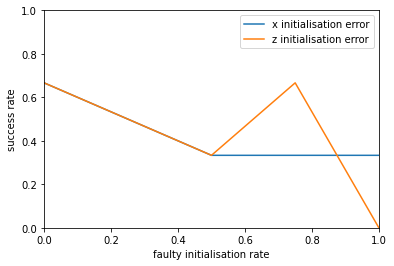

In [18]:

print(graph1)
print(graph2)
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
plt.plot(x_chance, graph1, label = "x initialisation error")
plt.plot(x_chance, graph2, label = "z initialisation error")
plt.xlabel("faulty initialisation rate")
plt.ylabel("success rate")
plt.legend()